Autoencoder has two operators: Encoder and Decoder.

**Encoder**: This transforms the input, x, into a low-dimensional latent vector,
𝒛 = 𝑓(𝒙). Since the latent vector is of low dimension, the encoder is forced
to learn only the most important features of the input data. For example,
in the case of MNIST digits, the important features to learn may include
writing style, tilt angle, roundness of stroke, thickness, and so on. Essentially,
these are the most important bits of information needed to represent the
digits zero to nine.
<br>
**Decoder**: This tries to recover the input from the latent vector, 𝑔(𝒛) = 𝒙
<br>
In our context, x can be an MNIST digit that has a dimension
of 28 × 28 × 1 = 784.
<br>
The encoder transforms the input into a low-dimensional vector (z) that
can be a 16-dimension latent vector. The decoder will attempt to recover the input in the form of 𝒙 from z.


 First, we are building an autoencoder.

In [92]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

Load MNIST Dataset
MNIST contains 70k grayscale images of handwritten digits (0 - 9). There are 60k images for training (x_train) and 10k for test (x_test).

Each image is 28x28 pixel.

"_" underscore is used to ignore the labels.

we could use (x_train, y_train), (x_test, y_test)

In [93]:
(x_train, _), (x_test, _) = mnist.load_data()

Automatically get the size of image using x_train.shape,<br> For MNIST dataset  image_size = 28

x_train = np.reshape(x_train, [-1, image_size, image_size, 1]).
This adds a channel dimension so that each image shape becomes (28, 28,1).

x_train.astype('float32')/255. This normalizes pixel values from [0, 255] to [0.0, 1.0] to improve training performance.


In [94]:
image_size = x_train.shape[1] # size = 28
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

Network Parameter

In [95]:
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16

This represents the number of filters in each convolutional layer of autoencoder.

[32, 64] means in Encoder:
* First layer: 32 filters
* Second layer: 64 filters

In Decoder Layer:
* First Layer: 64 filters
* Second Layer: 32 filters

In [96]:
layer_filters = [32, 64]

lets initialize the input layer of neural network for encoder.

In [97]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

Let's build the encoder part using a loop over layer_filters.

In [98]:
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

so we need shape info to build decoder model so we don't have to do hand computations. The input to the decoder's first Conv2DTranspose will have this shape which is (7, 7, 64). This is processed to decoder back as (28, 28 1)

In [99]:
shape = K.int_shape(x)

now, lets generate latent vector.

In [100]:
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

Instantiate encoder model

In [101]:
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_vector (Dense)           │ (None, 16)             │        50,192 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,008 (269.56 KB)

 Trainable params: 69,008 (269.56 KB)

 Non-trainable params: 0 (0.00 B)

Lets visualize the architecture of our ENCODER model.

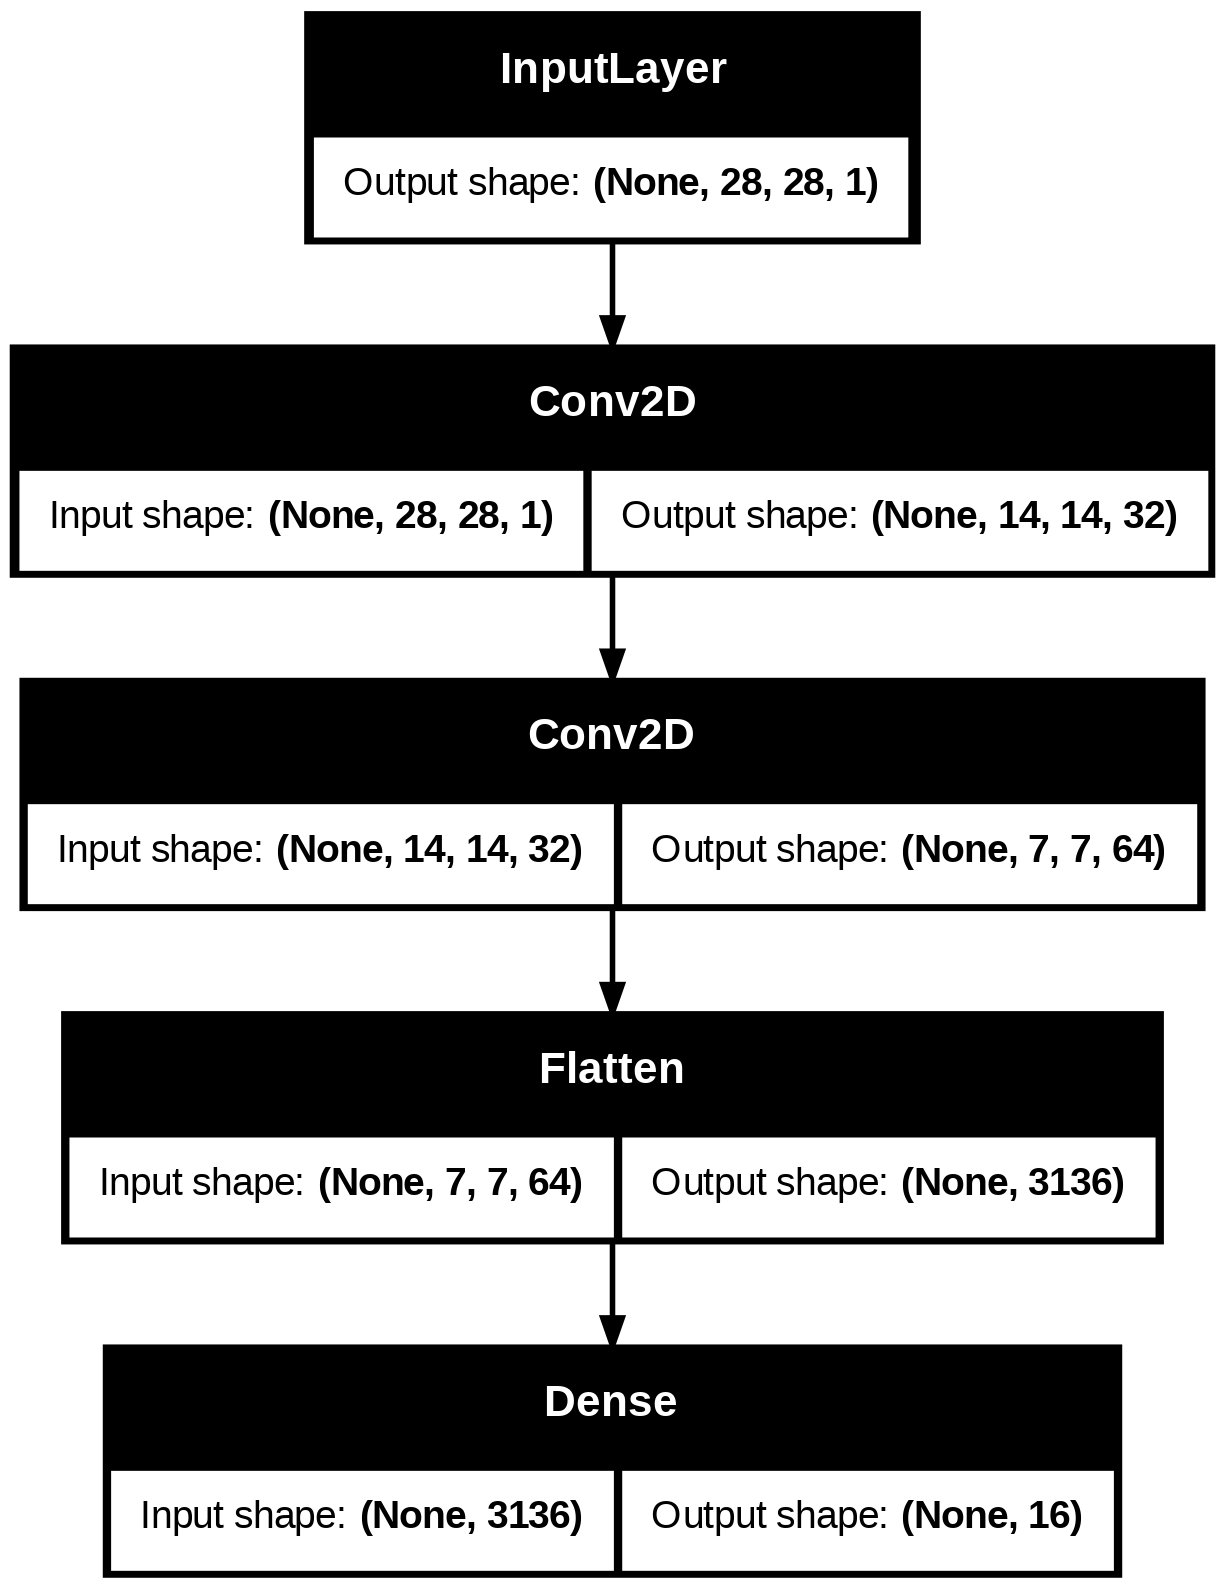

In [102]:
plot_model(encoder,
           to_file='encoder.png',
           show_shapes=True)

Let's build the decoder model

In [103]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')

lets use earlier saved shape size

In [104]:
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)

lets reshape from vector to transposed conv

In [105]:
x = Reshape((shape[1], shape[2], shape[3]))(x)

stack of Conv2DTranspose (64) into Conv2DTranspose (32)

In [106]:
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

reconstruct the input

In [107]:
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

instantiate the decoder model

In [108]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3136)           │        53,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_12             │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_13             │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output                  │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,993 (425.75 KB)

 Trainable params: 108,993 (425.75 KB)

 Non-trainable params: 0 (0.00 B)

Lets visualize the decoder model as well.

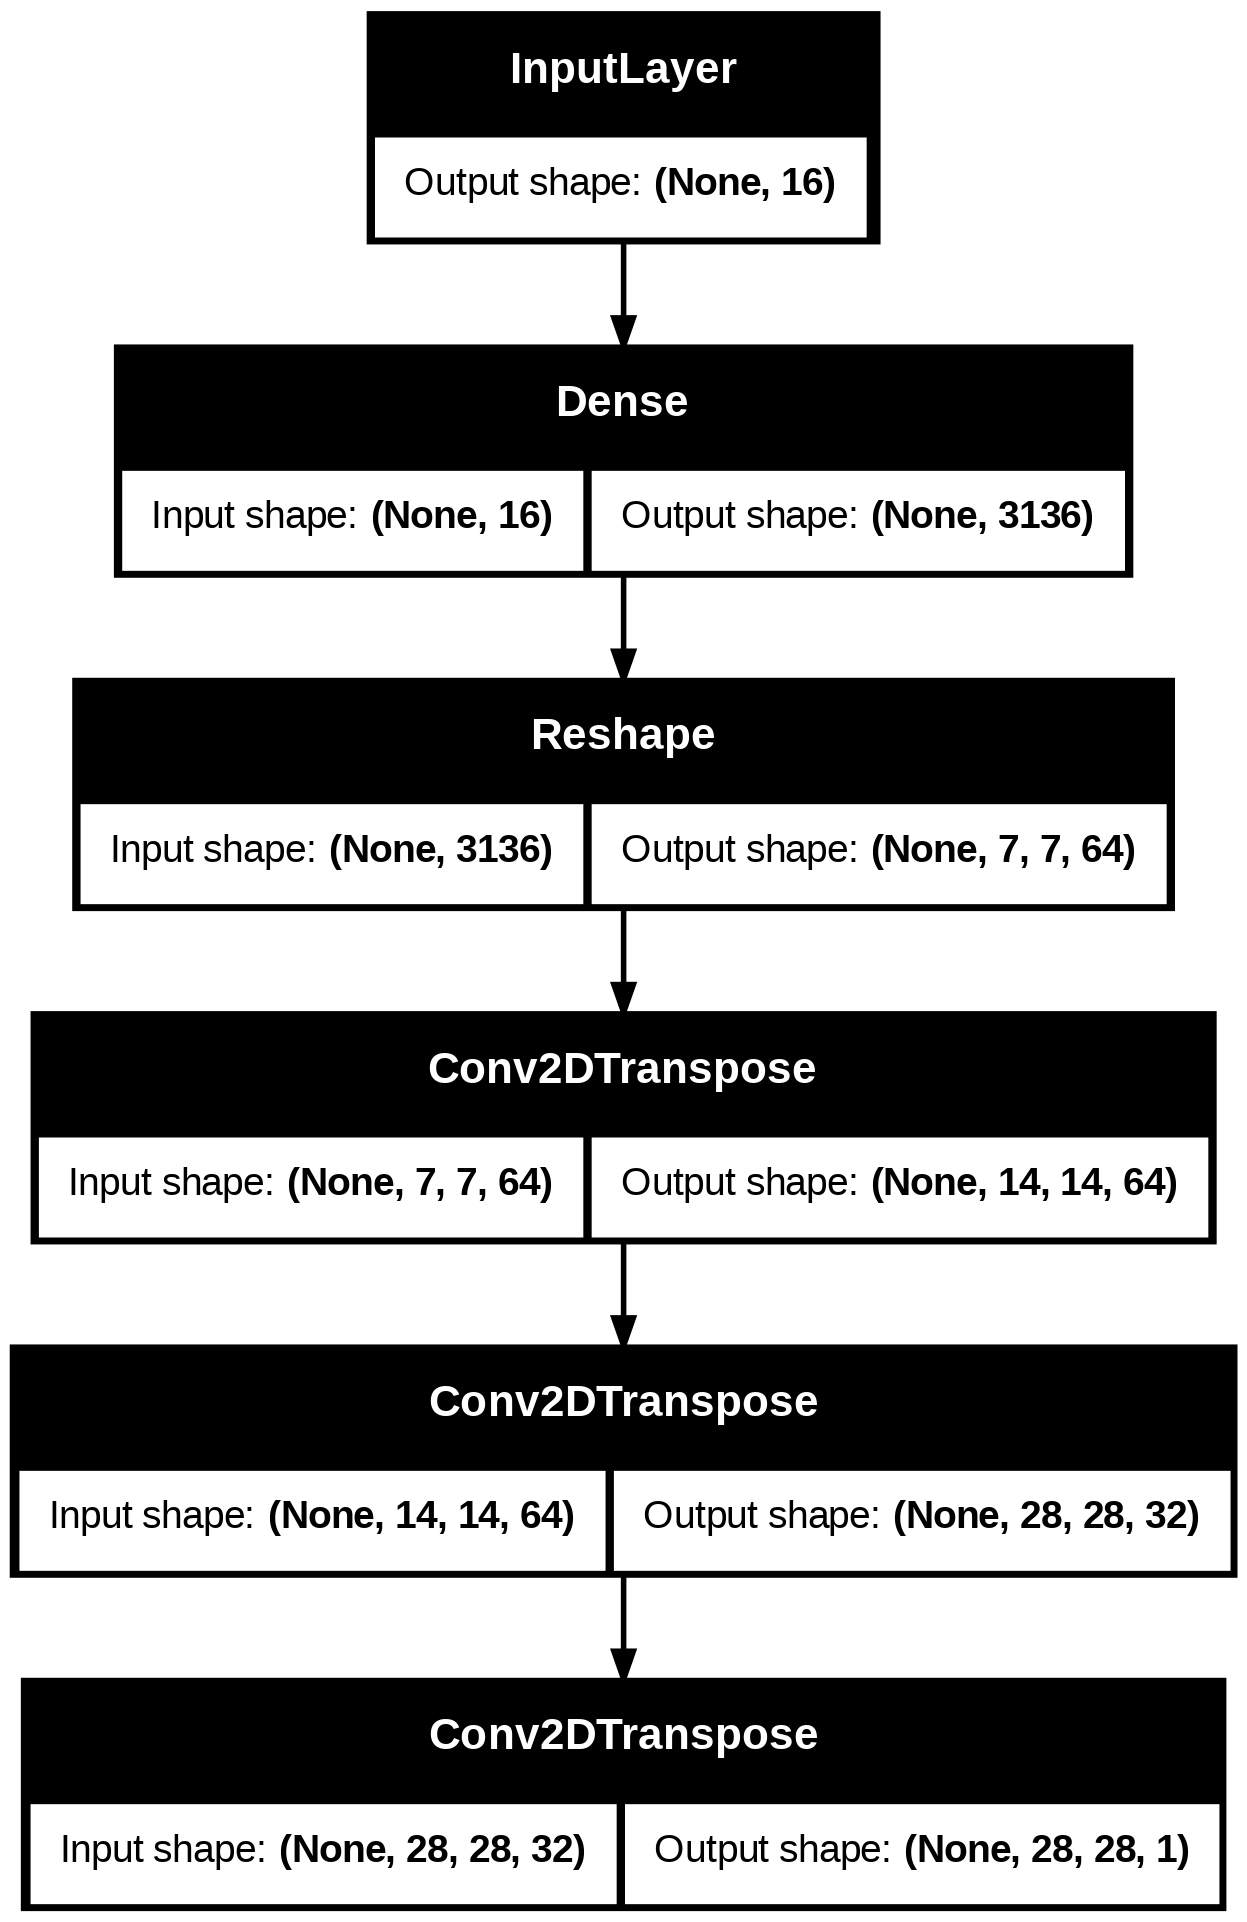

In [114]:
plot_model(decoder, to_file='decoder.png', show_shapes=True)

Now, let try and merge both models to instantiate autoencoder.

In [110]:
encoded = encoder(inputs)
decoded = decoder(encoded)
autoencoder = Model(inputs, decoded, name='autoencoder')
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 16)             │        69,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 28, 28, 1)      │       108,993 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,001 (695.32 KB)

 Trainable params: 178,001 (695.32 KB)

 Non-trainable params: 0 (0.00 B)

Visually, autoencoder looks like this.

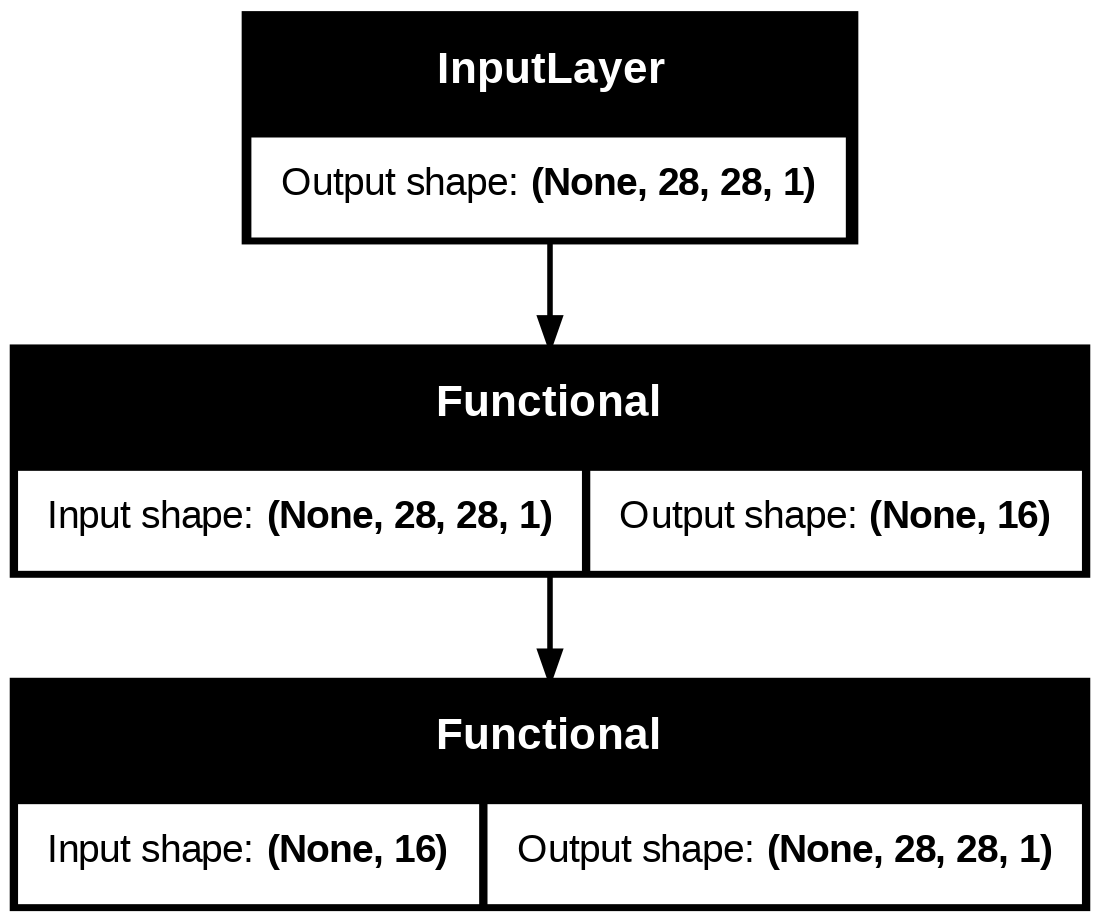

In [111]:
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)

Lets calculate loss function as well. WE will be using Mean Square Error (MSE) loss function, Adam optimizer.

In [112]:
autoencoder.compile(loss='mse', optimizer='adam')

Lets train the autoencoder.

In [113]:
autoencoder.fit(x_train,
                x_train,
                validation_data=(x_test, x_test),
                epochs=1,
                batch_size=batch_size)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 121s 63ms/step - loss: 0.0446 - val_loss: 0.0104


Finally, lets predict the autoencoder output from test data

In [115]:
x_decoded = autoencoder.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


display first 8 test input and decode images

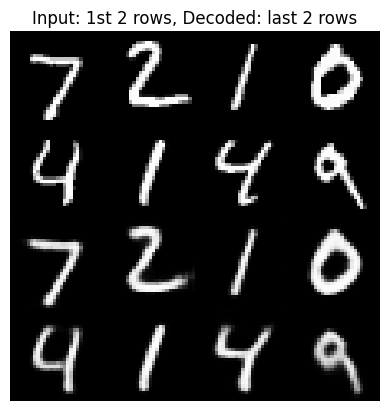

In [116]:
imgs = np.concatenate([x_test[:8], x_decoded[:8]])
imgs = imgs.reshape((4, 4, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Input: 1st 2 rows, Decoded: last 2 rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('input_and_decoded.png')
plt.show()